In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import cmcrameri.cm as cm

from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
from utils import ELFData, ELFModel

## Load and filter data

In [2]:
# Perform center crop
center = False

In [3]:
# Load labeled data
labeled = ELFData()
labeled.load_processed(dirname='data/labeled', structure=False)
print('Number of examples:', len(labeled.data))
labeled.data.head()

Parse profiles: 100%|██████████| 2376/2376 [00:00<00:00, 15534.68it/s]          

Number of examples: 2376


,formula,label,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.001087356613359765, 0...",1.43,0,4,1.913597,0.6,2,Al,N,False,0
1,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0013045701442416335, ...",1.43,0,6,1.901737,0.6,2,Al,N,False,0
2,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0010438078812688811, ...",1.43,0,7,1.901727,0.6,2,Al,N,False,0
3,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012458509658890753,...",1.43,1,5,1.913597,0.6,2,Al,N,False,0
4,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012551757001977302,...",1.43,1,6,1.901721,0.6,2,Al,N,False,0


In [4]:
# Center crop
if center:
    dx = len(labeled.data.iloc[0]['elf'])//4
    labeled.data['elf'] = labeled.data['elf'].apply(lambda x: x[dx:-dx])

In [5]:
# Sort and filter labeled data
labeled.data = labeled.data[~labeled.data['mixed']].reset_index(drop=True)
labeled.get_pdf_cdf()
labeled.sort_by_cdf()
labeled.drop_duplicates(column='elf_srt', precision=1e-6)
print('Number of examples:', len(labeled.data_nodup), '/', len(labeled.data))
labeled.data_nodup.head()

Drop duplicates: 100%|██████████| 2270/2270 [00:00<00:00, 420152.25it/s]        

Number of examples: 1069 / 2270


,formula,label,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.001087356613359765, 0...",1.43,...,Al,N,False,0,15.385578,"[8.012886094998199e-05, 7.067375815616856e-05,...","[8.012886094998199e-05, 0.00015080261910615055...","[0.08308545137254143, 0.10515383510944412, 0.1...","[0.005400216474019171, 0.00683457167631135, 0....","[0.005400216474019171, 0.012234788150330522, 0..."
1,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0013045701442416335, ...",1.43,...,Al,N,False,0,15.685452,"[7.859695799504034e-05, 8.317070625344013e-05,...","[7.859695799504034e-05, 0.0001617676642484805,...","[0.06265302144689675, 0.06310666281674325, 0.0...","[0.003994339488490676, 0.004023260641778179, 0...","[0.003994339488490676, 0.008017600130268854, 0..."
2,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0010438078812688811, ...",1.43,...,Al,N,False,0,15.526640,"[7.940087478587706e-05, 6.722689848191011e-05,...","[7.940087478587706e-05, 0.00014662777326778718...","[0.06806385687435311, 0.07085087984300932, 0.1...","[0.004383682168424542, 0.00456318158928812, 0....","[0.004383682168424542, 0.008946863757712663, 0..."
3,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012458509658890753,...",1.43,...,Al,N,False,0,15.375489,"[9.350321931154114e-05, 8.10283804602425e-05, ...","[9.350321931154114e-05, 0.00017453159977178363...","[0.09592359802999166, 0.11944143191680953, 0.1...","[0.006238734815879705, 0.007768301388412691, 0...","[0.006238734815879705, 0.014007036204292396, 0..."
4,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012551757001977302,...",1.43,...,Al,N,False,0,14.016815,"[0.0001025666447661523, 8.954785207195599e-05,...","[0.0001025666447661523, 0.0001921144968381083,...","[0.06265302144689669, 0.06313083846175346, 0.0...","[0.004469847126186371, 0.0045039359691723515, ...","[0.004469847126186371, 0.008973783095358723, 0..."


In [6]:
# Load unlabeled data
unlabeled = ELFData()
unlabeled.load_processed(dirname='data/unlabeled', structure=False)
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Parse profiles: 100%|██████████| 320585/320585 [00:19<00:00, 16870.60it/s]      


Number of examples: 320585


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,4,3.812422,1.2,16,K,Cl,False,0
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,5,3.812422,1.2,16,K,Cl,False,0
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,6,3.812422,1.2,16,K,Cl,False,0
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,7,3.812422,1.2,16,K,Cl,False,0
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,8,3.812422,1.2,16,K,Cl,False,0


In [7]:
# Center crop
if center:
    dx = len(unlabeled.data.iloc[0]['elf'])//4
    unlabeled.data['elf'] = unlabeled.data['elf'].apply(lambda x: x[dx:-dx])

In [8]:
# Sort and filter unlabeled data
unlabeled.data = unlabeled.data[~unlabeled.data['mixed']].reset_index(drop=True)
unlabeled.get_pdf_cdf()
unlabeled.sort_by_cdf()
unlabeled.drop_duplicates(column='elf_srt', precision=1e-6)
print('Number of examples:', len(unlabeled.data_nodup), '/', len(unlabeled.data))
unlabeled.data_nodup.head()

Drop duplicates: 100%|██████████| 279511/279511 [00:00<00:00, 435869.28it/s]    


Number of examples: 157526 / 279511


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,100,2.20,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
1,100,2.20,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.22271259596505436, 0.18323072767531332, 0.1...","[0.018490642709179408, 0.015212673105021801, 0...","[0.018490642709179408, 0.03370331581420121, 0...."
2,100,2.20,1.0,0.82,3.16,1,17,"[0.00010800984375009326, 2.3885327660440446e-0...",2.34,1,...,K,Cl,False,0,11.260210,"[9.592169849024623e-06, 2.1212151769116214e-06...","[9.592169849024623e-06, 1.1713385025936245e-05...","[0.17050112862077707, 0.2695927432329129, 0.40...","[0.015141914184830721, 0.02394207132766407, 0....","[0.015141914184830721, 0.03908398551249479, 0...."
3,100,2.20,1.0,0.82,3.16,1,17,"[0.00010800984375009326, 6.923466566612244e-05...",2.34,1,...,K,Cl,False,0,11.906502,"[9.071501210628336e-06, 5.814862160719823e-06,...","[9.071501210628336e-06, 1.4886363371348159e-05...","[0.22271259596505424, 0.2599386297866774, 0.34...","[0.018705124586548848, 0.02183165453192204, 0....","[0.018705124586548848, 0.04053677911847089, 0...."
4,100,1.55,1.0,1.78,3.16,13,17,"[0.5108699999999999, 0.5157627966196754, 0.517...",1.38,2,...,In,Cl,False,0,19.641076,"[0.026010285260979822, 0.026259395672242405, 0...","[0.026010285260979822, 0.05226968093322223, 0....","[0.5108699999999999, 0.5157627966196754, 0.517...","[0.026010285260979822, 0.026259395672242405, 0...","[0.026010285260979822, 0.05226968093322223, 0...."


## Analyze data

### Bond length and area statistics

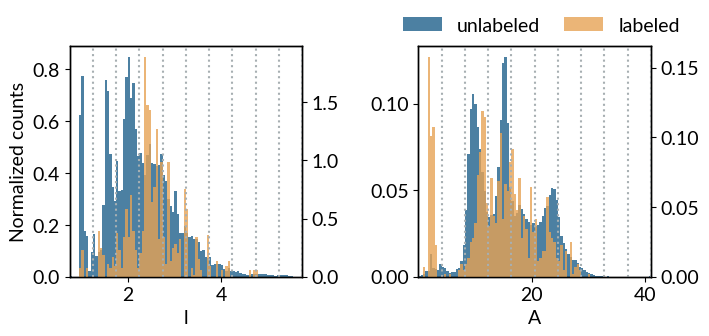

In [9]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.5)

_ax = ax[0].twinx()
_, bins, _ = ax[0].hist(unlabeled.data_nodup['l'], bins=100, density=True, color=unlabeled.palette[0], alpha=0.8)
_ax.hist(labeled.data_nodup['l'], bins=bins, density=True, color=unlabeled.palette[2], alpha=0.8)
_, bins = np.histogram(unlabeled.data_nodup['l'], bins=10)
ax[0].set_xlim([bins[0], bins[-1]])
ax[0].set_xlabel('l')
ax[0].set_ylabel('Normalized counts')
for k in bins:
    _ax.axvline(k, color=unlabeled.palette[1], ls=':')

_ax = ax[1].twinx()
_, bins, _ = ax[1].hist(unlabeled.data_nodup['A'], bins=100, density=True, color=unlabeled.palette[0], alpha=0.8,
                        label='unlabeled')
_ax.hist(labeled.data_nodup['A'], bins=bins, density=True, color=unlabeled.palette[2], alpha=0.8, label='labeled')
_, bins = np.histogram(unlabeled.data_nodup['A'], bins=10)
ax[1].set_xlim([bins[0], bins[-1]])
ax[1].set_xlabel('A')
ax[1].legend(frameon=False, loc='upper right', bbox_to_anchor=(0.6,1.2))
_ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2,1.2))
for k in bins:
    _ax.axvline(k, color=unlabeled.palette[1], ls=':')

In [10]:
n_bins = 10
_, bins = np.histogram(unlabeled.data_nodup['l'], bins=n_bins)
labeled.data_nodup['l_bin'] = np.digitize(labeled.data_nodup['l'], bins[:-1], right=False).tolist()

_, bins = np.histogram(unlabeled.data_nodup['A'], bins=n_bins)
labeled.data_nodup['A_bin'] = np.digitize(labeled.data_nodup['A'], bins[:-1], right=False).tolist()

## Featurize data

### PCA

In [11]:
n_classes = 4
n_components = 12
target = 0.995

#### Sorted ELF profiles

Number of components: 8


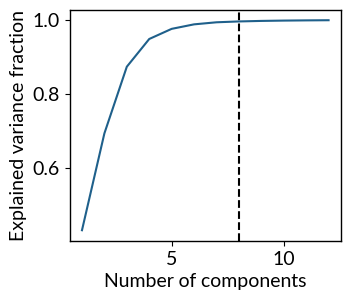

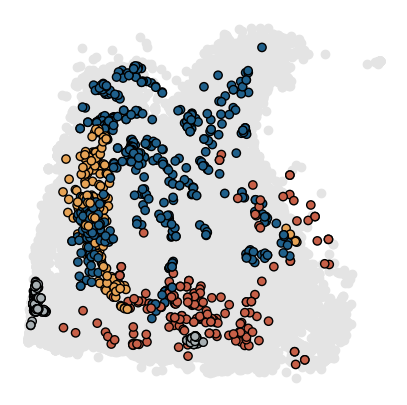

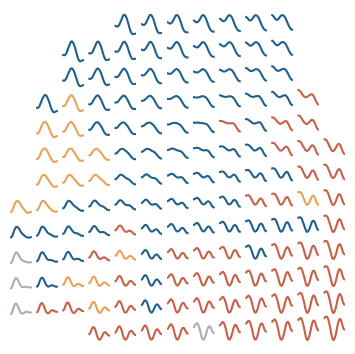

In [12]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='elf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

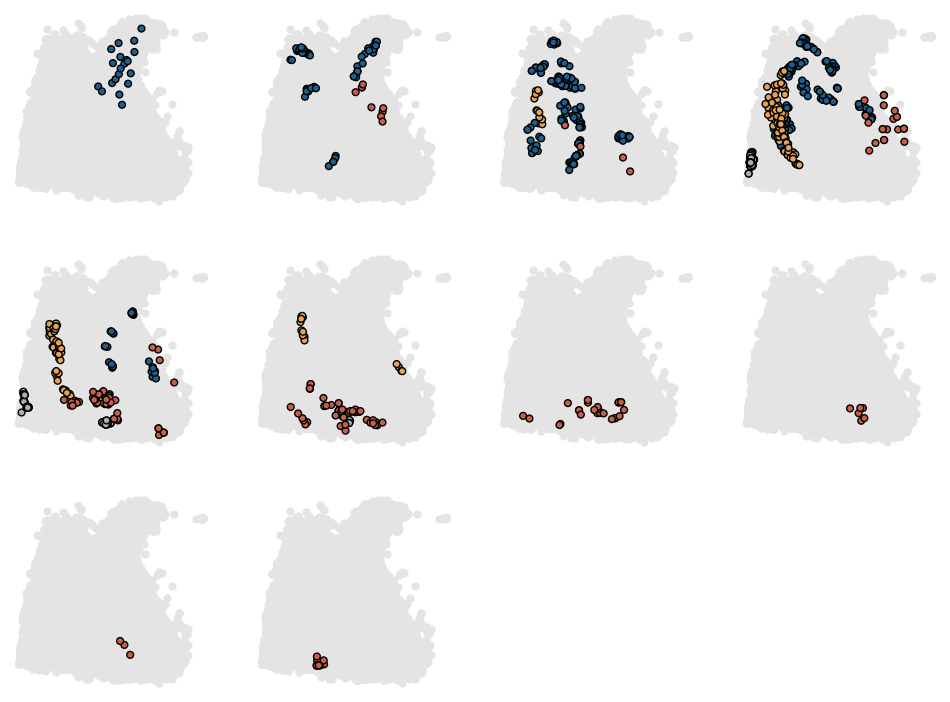

In [13]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

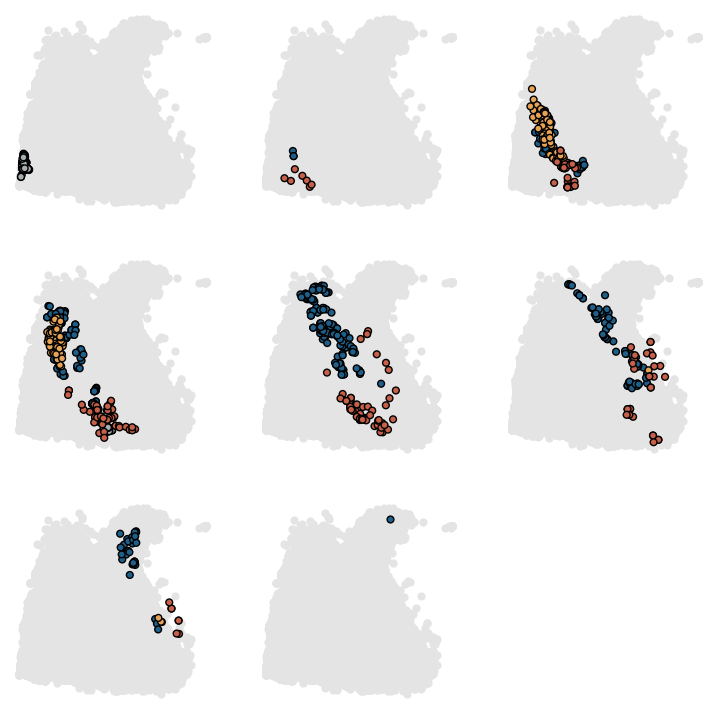

In [14]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

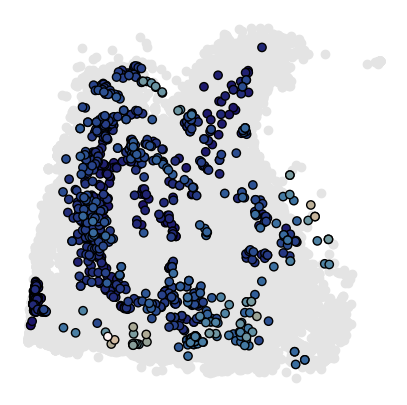

,formula,d_elf_srt_euc,label,l,specie_src,specie_dst
642,MoSSe_vdw,0.468446,vdw,5.862218,Mo,Se
863,S_vdw,0.478539,vdw,4.117780,S,S
654,MoSTe_vdw,0.498140,vdw,5.833844,Mo,Te
655,MoSTe_vdw,0.510328,vdw,5.833844,Mo,Te
122,C_vdw,0.513626,vdw,3.723139,C,C
403,H2S_vdw,0.530911,vdw,2.691945,S,H
404,H2S_vdw,0.546309,vdw,2.691945,S,H
420,H2S_vdw,0.546309,vdw,2.691945,H,S
123,C_vdw,0.561076,vdw,3.723138,C,C
121,C_vdw,0.686795,vdw,3.723138,C,C


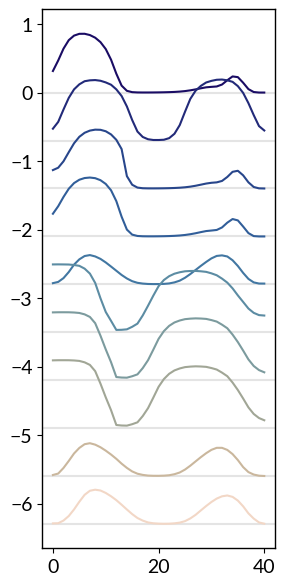

In [15]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='elf_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='elf_srt', metric='euclidean')

y = labeled.data_nodup['d_elf_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['elf_srt']  - 0.7*i, color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_elf_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted PDFs of ELF profiles

Number of components: 10


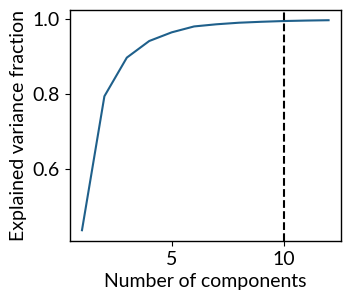

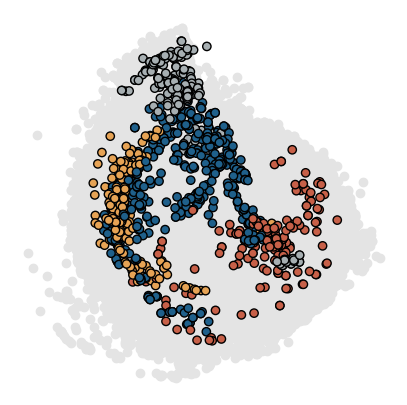

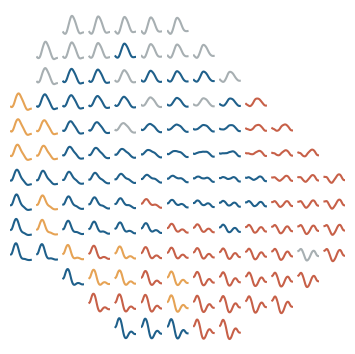

In [16]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='pdf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

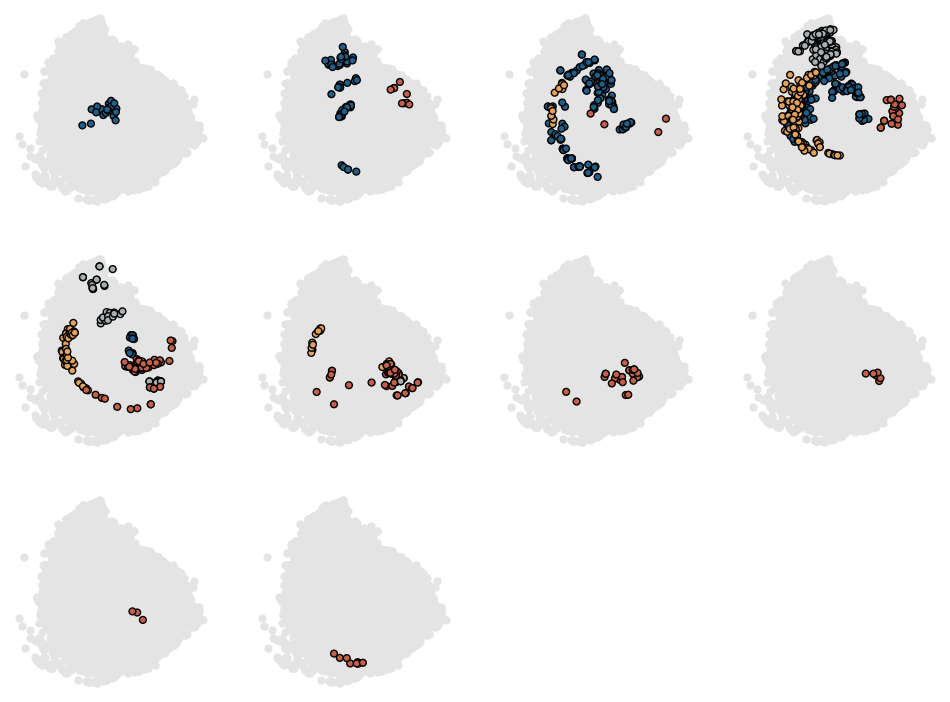

In [17]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

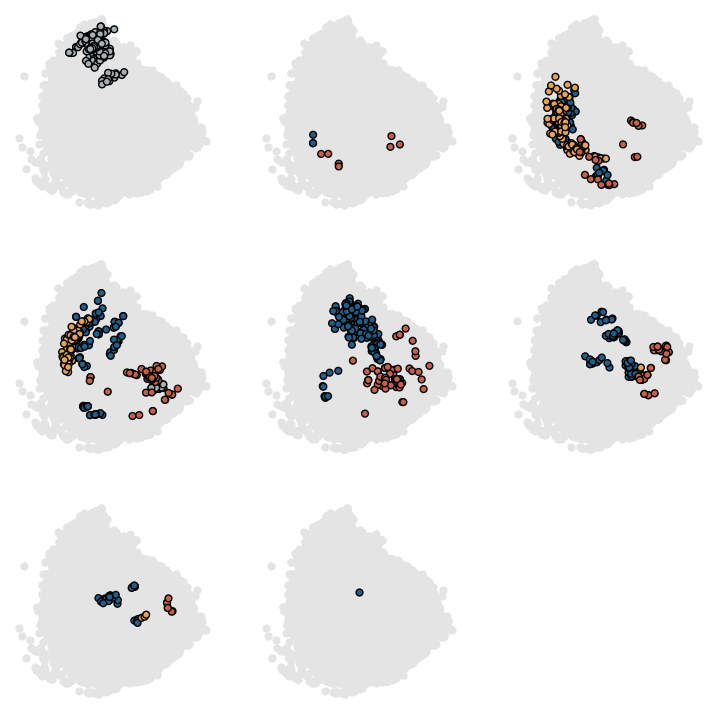

In [18]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

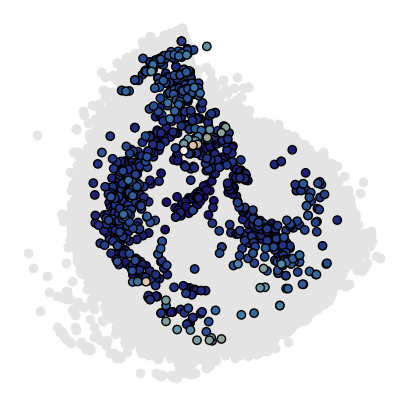

,formula,d_pdf_srt_euc,label,l,specie_src,specie_dst
654,MoSTe_vdw,0.034769,vdw,5.833844,Mo,Te
656,MoSTe_vdw,0.036292,vdw,6.215416,Mo,S
140,CdPd,0.036408,metallic,2.867828,Cd,Pd
136,CdPd,0.036585,metallic,2.867828,Cd,Pd
657,MoSTe_vdw,0.037433,vdw,6.215416,Mo,S
137,CdPd,0.039610,metallic,2.867828,Cd,Pd
138,CdPd,0.046256,metallic,2.867828,Cd,Pd
146,CdPd,0.048117,metallic,2.867828,Pd,Cd
80,BNC2_vdw,0.048502,vdw,3.742767,C,B
148,CdPd,0.057143,metallic,2.867828,Pd,Cd


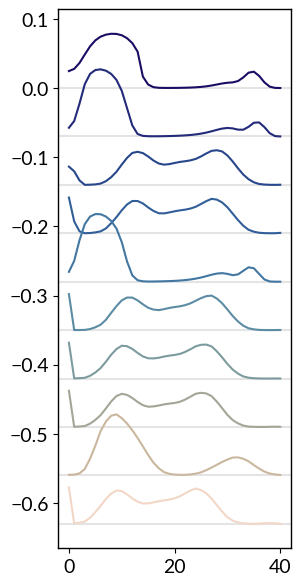

In [19]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='pdf_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='pdf_srt', metric='euclidean')

y = labeled.data_nodup['d_pdf_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['pdf_srt']  - 0.07*i, color=model.cmap(norm(i)))
    ax.axhline(-0.07*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_pdf_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted PDFs of ELF profiles normalized by bond length

Number of components: 8


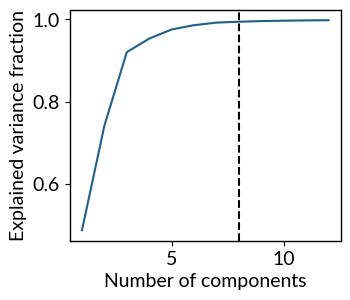

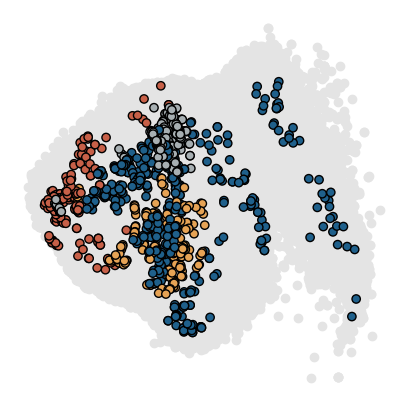

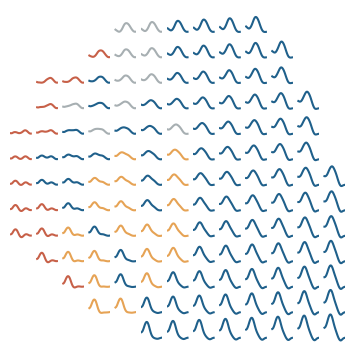

In [20]:
model = ELFModel(n_classes)

unlabeled.data_nodup['pdf-l_srt'] = unlabeled.data_nodup[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)
labeled.data_nodup['pdf-l_srt'] = labeled.data_nodup[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='pdf-l_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

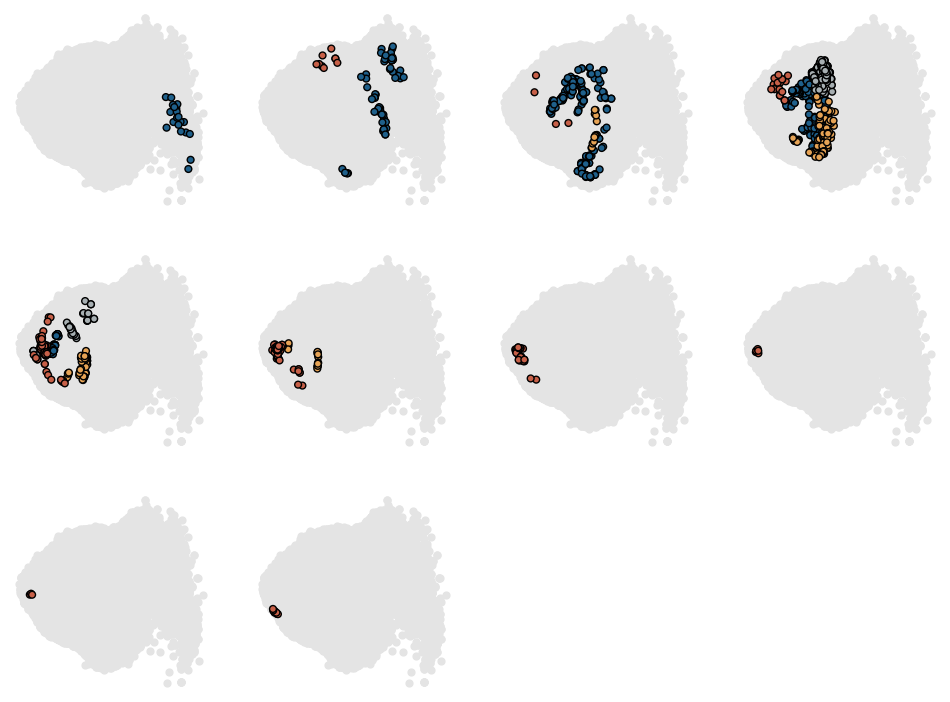

In [21]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

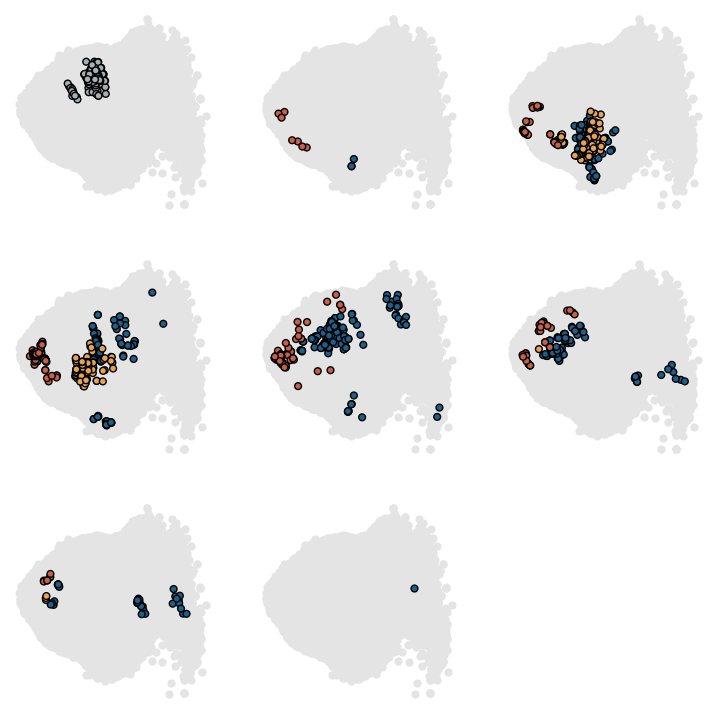

In [22]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

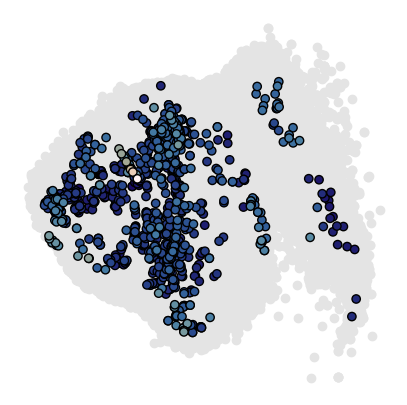

,formula,d_pdf-l_srt_euc,label,l,specie_src,specie_dst
969,V2,0.478072,metallic,2.591619,V,V
657,MoSTe_vdw,0.480976,vdw,6.215416,Mo,S
186,CrH2,0.485330,covalent,1.778052,Cr,H
80,BNC2_vdw,0.530312,vdw,3.742767,C,B
140,CdPd,0.545501,metallic,2.867828,Cd,Pd
136,CdPd,0.558088,metallic,2.867828,Cd,Pd
137,CdPd,0.579866,metallic,2.867828,Cd,Pd
138,CdPd,0.649145,metallic,2.867828,Cd,Pd
146,CdPd,0.706028,metallic,2.867828,Pd,Cd
148,CdPd,0.806321,metallic,2.867828,Pd,Cd


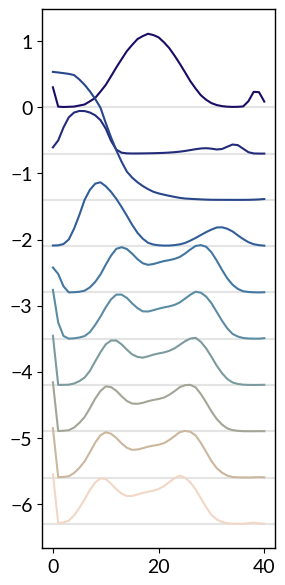

In [23]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='pdf-l_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='pdf-l_srt', metric='euclidean')

y = labeled.data_nodup['d_pdf-l_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['pdf-l_srt']  - 0.7*i, color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_pdf-l_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted CDFs of ELF profiles

Number of components: 4


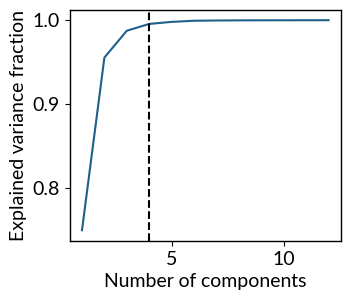

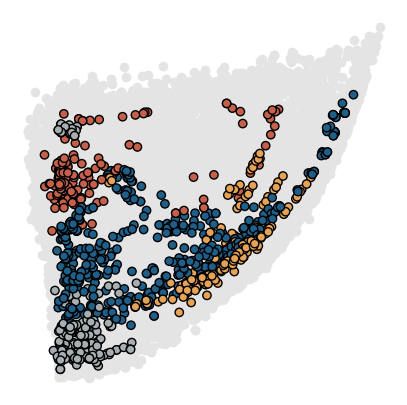

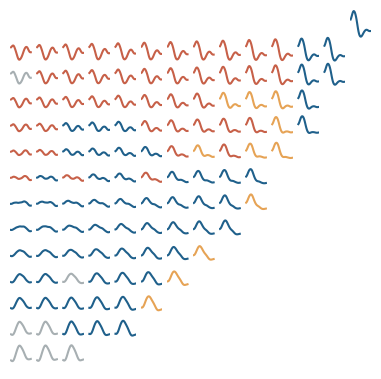

In [24]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='cdf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

derivative = lambda x, y: UnivariateSpline(x, y, k=4, s=0).derivative()(x)
fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap, transform=derivative)

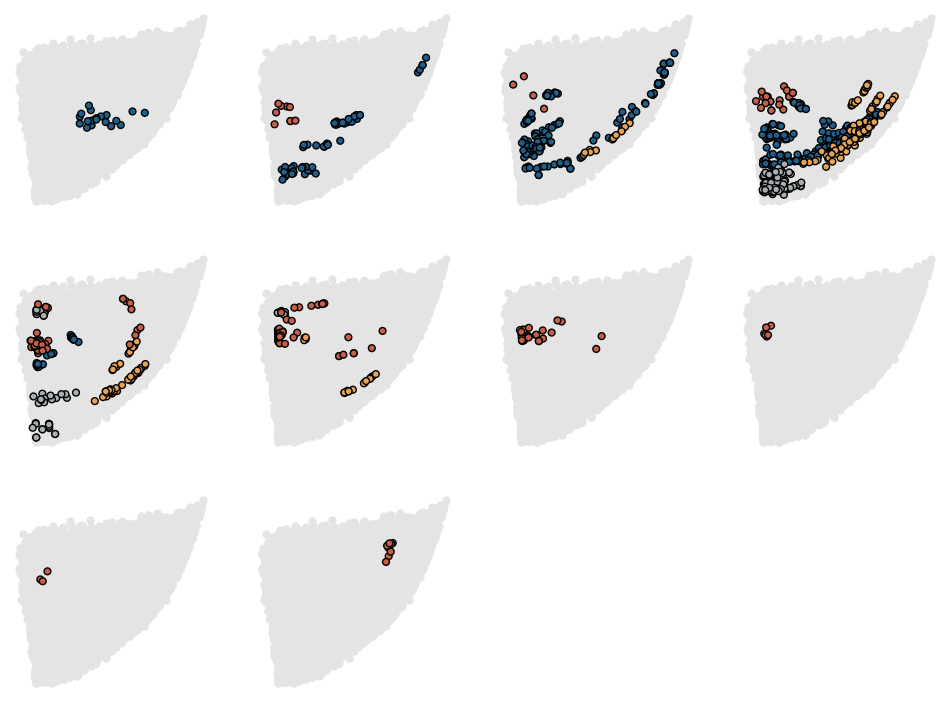

In [25]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

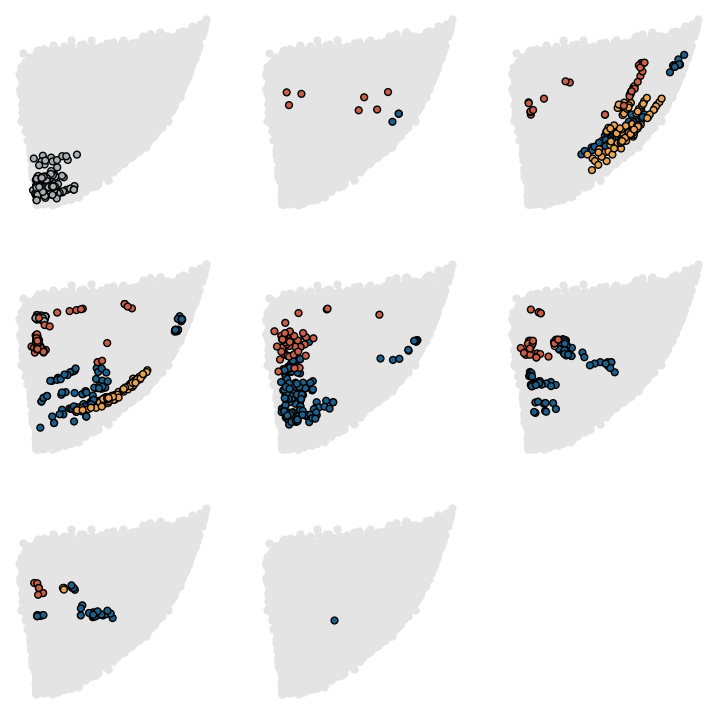

In [26]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

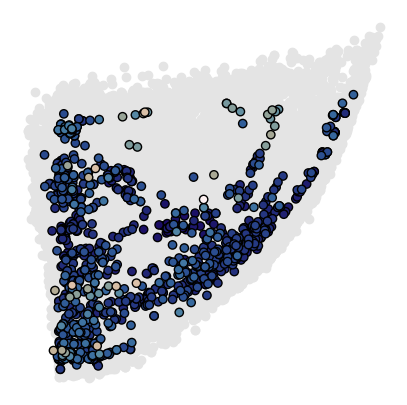

,formula,d_cdf_srt_l1,label,l,specie_src,specie_dst
140,CdPd,0.555688,metallic,2.867828,Cd,Pd
121,C_vdw,0.575707,vdw,3.723138,C,C
963,Ti3,0.580937,metallic,2.828683,Ti,Ti
969,V2,0.600830,metallic,2.591619,V,V
146,CdPd,0.605571,metallic,2.867828,Pd,Cd
426,H2S_vdw,0.611690,vdw,3.480120,S,H
123,C_vdw,0.612435,vdw,3.723138,C,C
136,CdPd,0.617194,metallic,2.867828,Cd,Pd
148,CdPd,0.618724,metallic,2.867828,Pd,Cd
80,BNC2_vdw,0.735225,vdw,3.742767,C,B


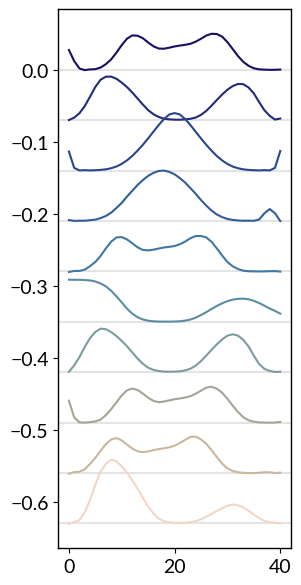

In [27]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='cdf_srt', metric='l1')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='cdf_srt', metric='l1')

y = labeled.data_nodup['d_cdf_srt_l1'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(derivative(range(len(labeled.data_nodup.iloc[0].elf)), labeled.data_nodup.iloc[idx]['cdf_srt']) - 0.07*i,
            color=model.cmap(norm(i)))
    ax.axhline(-0.07*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_cdf_srt_l1', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted CDFs of ELF profiles scaled by area

Number of components: 3


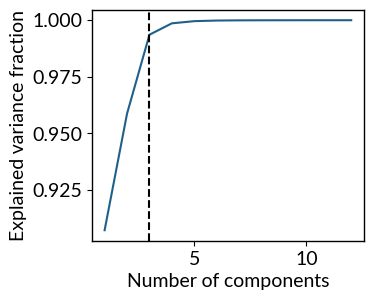

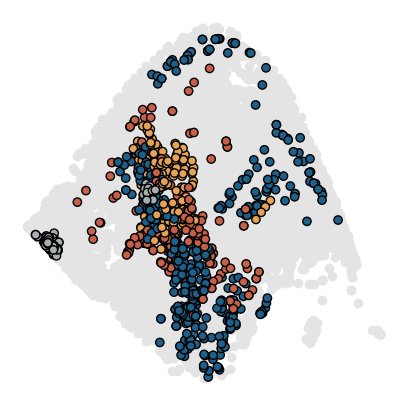

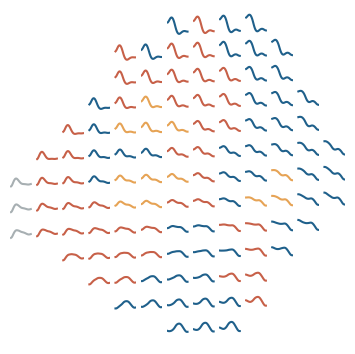

In [28]:
model = ELFModel(n_classes)

unlabeled.data_nodup['cdf-A_srt'] = unlabeled.data_nodup[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)
labeled.data_nodup['cdf-A_srt'] = labeled.data_nodup[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='cdf-A_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

derivative = lambda x, y: UnivariateSpline(x, y, k=4, s=0).derivative()(x)
fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap, transform=derivative)

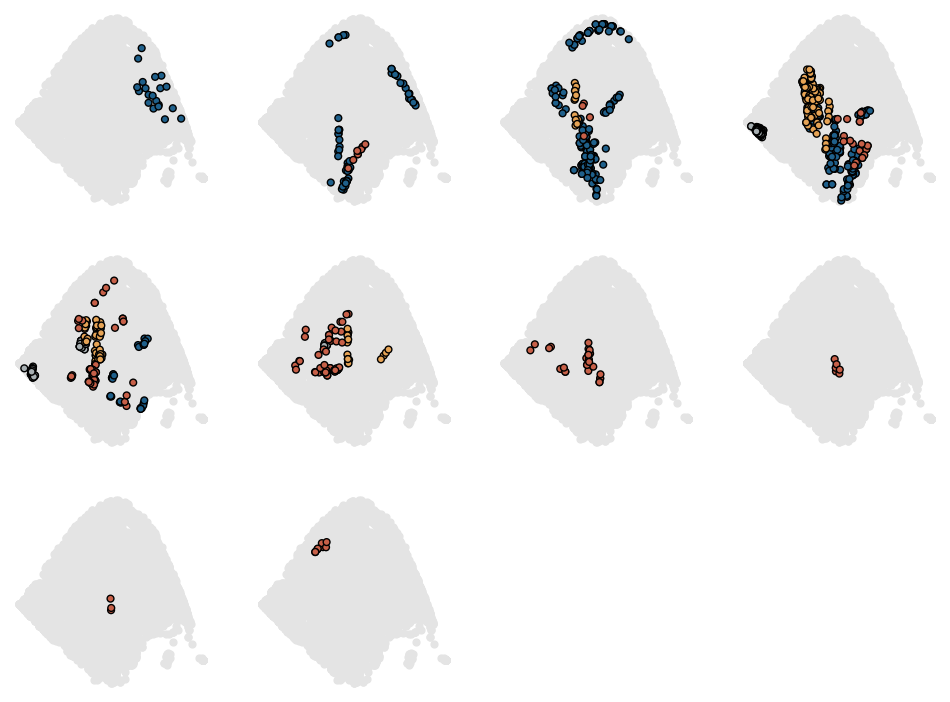

In [29]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

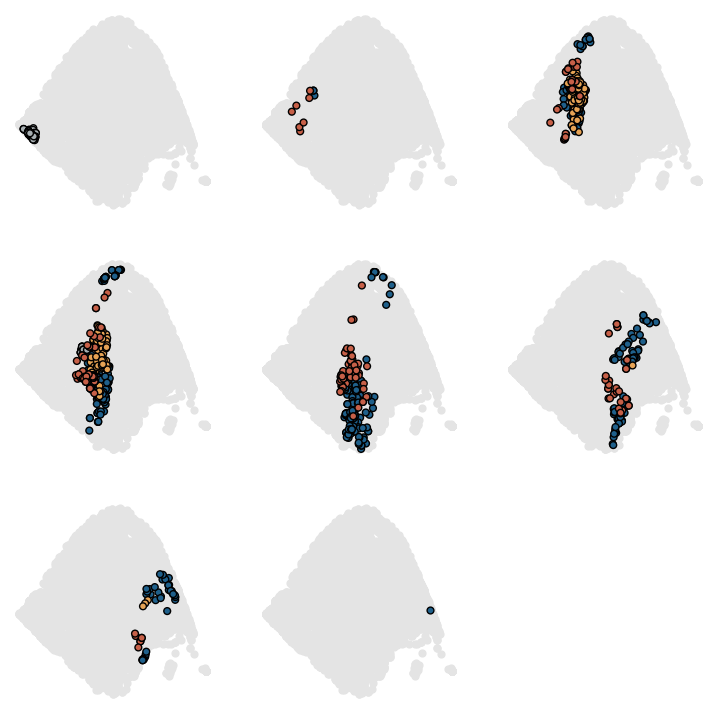

In [30]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

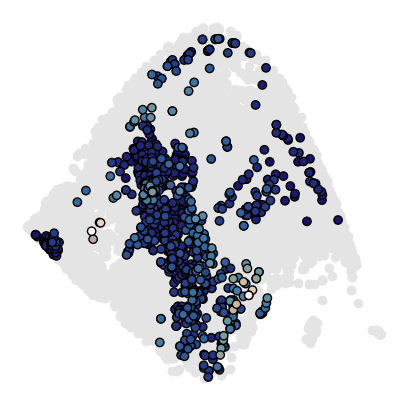

,formula,d_cdf-A_srt_l1,label,l,specie_src,specie_dst
416,H2S_vdw,16.216498,vdw,2.749719,H,S
405,H2S_vdw,16.909471,vdw,2.691945,S,H
406,H2S_vdw,17.073929,vdw,2.691945,S,H
409,H2S_vdw,17.405920,vdw,2.691945,S,H
123,C_vdw,18.050121,vdw,3.723138,C,C
403,H2S_vdw,18.363277,vdw,2.691945,S,H
121,C_vdw,18.870331,vdw,3.723138,C,C
408,H2S_vdw,21.076634,vdw,2.691945,S,H
419,H2S_vdw,21.076634,vdw,2.691945,H,S
122,C_vdw,21.228262,vdw,3.723139,C,C


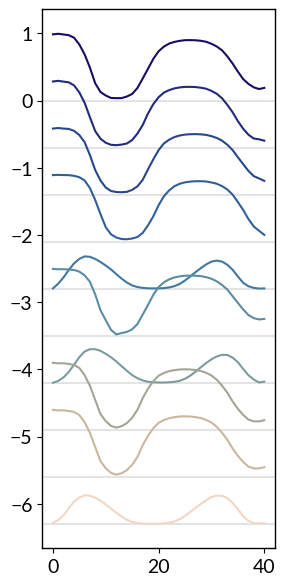

In [31]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='cdf-A_srt', metric='l1')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='cdf-A_srt', metric='l1')

y = labeled.data_nodup['d_cdf-A_srt_l1'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(derivative(range(len(labeled.data_nodup.iloc[0].elf)), labeled.data_nodup.iloc[idx]['cdf-A_srt']) - 0.7*i,
            color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_cdf-A_srt_l1', 'label', 'l', 'specie_src', 'specie_dst']]

## Optimize hyperparameters

In [198]:
n_classes = 4
n_components = 3
#columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
#columns = [['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']]
columns = [['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt'],
           ['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf-A_srt'],
           ['elf_srt', 'pdf_srt', 'cdf_srt', 'cdf-A_srt'],
           ['elf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt'],
           ['pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']]
features = [[], ['l'], ['A'], ['l', 'A']]

### Featurize data

In [199]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Split data

In [200]:
test_size = 0.2
valid_size = 0.2

In [201]:
idx_train, idx_test = models[0].split(labeled.data_nodup, test_size, stratify=True)

y_train = models[0].bond_to_float(labeled.data_nodup.iloc[idx_train]['label'].tolist())
y_test = models[0].bond_to_float(labeled.data_nodup.iloc[idx_test]['label'].tolist())
class_weight = len(y_train)/(n_classes*np.bincount(y_train))

print('Train (Total):', len(idx_train), '\tTest:', len(idx_test))
print('Train (Bootstrap):', round((1 - valid_size)*len(idx_train)),
      '\tValid (Bootstrap):', round(valid_size*len(idx_train)))
print('Class weights:', list(class_weight))

Train (Total): 855 	Test: 214
Train (Bootstrap): 684 	Valid (Bootstrap): 171
Class weights: [0.5370603015075377, 1.3194444444444444, 1.4540816326530612, 1.4442567567567568]


### Train classifiers

In [202]:
n_estimators = np.arange(20, 205, 10)
max_depth = np.arange(8, 15, 2)
scores = np.zeros((len(columns), len(features), len(n_estimators), len(max_depth)))
oob_scores = np.zeros((len(columns), len(features), len(n_estimators), len(max_depth)))

In [203]:
for i in range(len(columns)):
    print(columns[i], ':', flush=True)
    inputs_list = [['z_' + k for k in columns[i]] + f for f in features]
    for j, inputs in enumerate(inputs_list):
        models[i].set_inputs(inputs)
        models[i].scaler_fit(unlabeled.data_nodup)
        models[i].prepare_inputs(labeled.data_nodup)

        x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
        x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)

        for l, n in tqdm(enumerate(n_estimators), total=len(n_estimators), bar_format=labeled.bar_format):
            for m, d in enumerate(max_depth):
                models[i].clf_init(n, d, 1 - valid_size)
                models[i].clf.fit(x_train, y_train)
                scores[i,j,l,m] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])
                oob_scores[i,j,l,m] = models[i].clf.oob_score_

['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt'] :


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]                                 

['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf-A_srt'] :



100%|██████████| 19/19 [00:13<00:00,  1.43it/s]                                 

['elf_srt', 'pdf_srt', 'cdf_srt', 'cdf-A_srt'] :



100%|██████████| 19/19 [00:12<00:00,  1.46it/s]                                 

['elf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt'] :



100%|██████████| 19/19 [00:12<00:00,  1.46it/s]                                 

['pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt'] :



100%|██████████| 19/19 [00:13<00:00,  1.45it/s]                                 


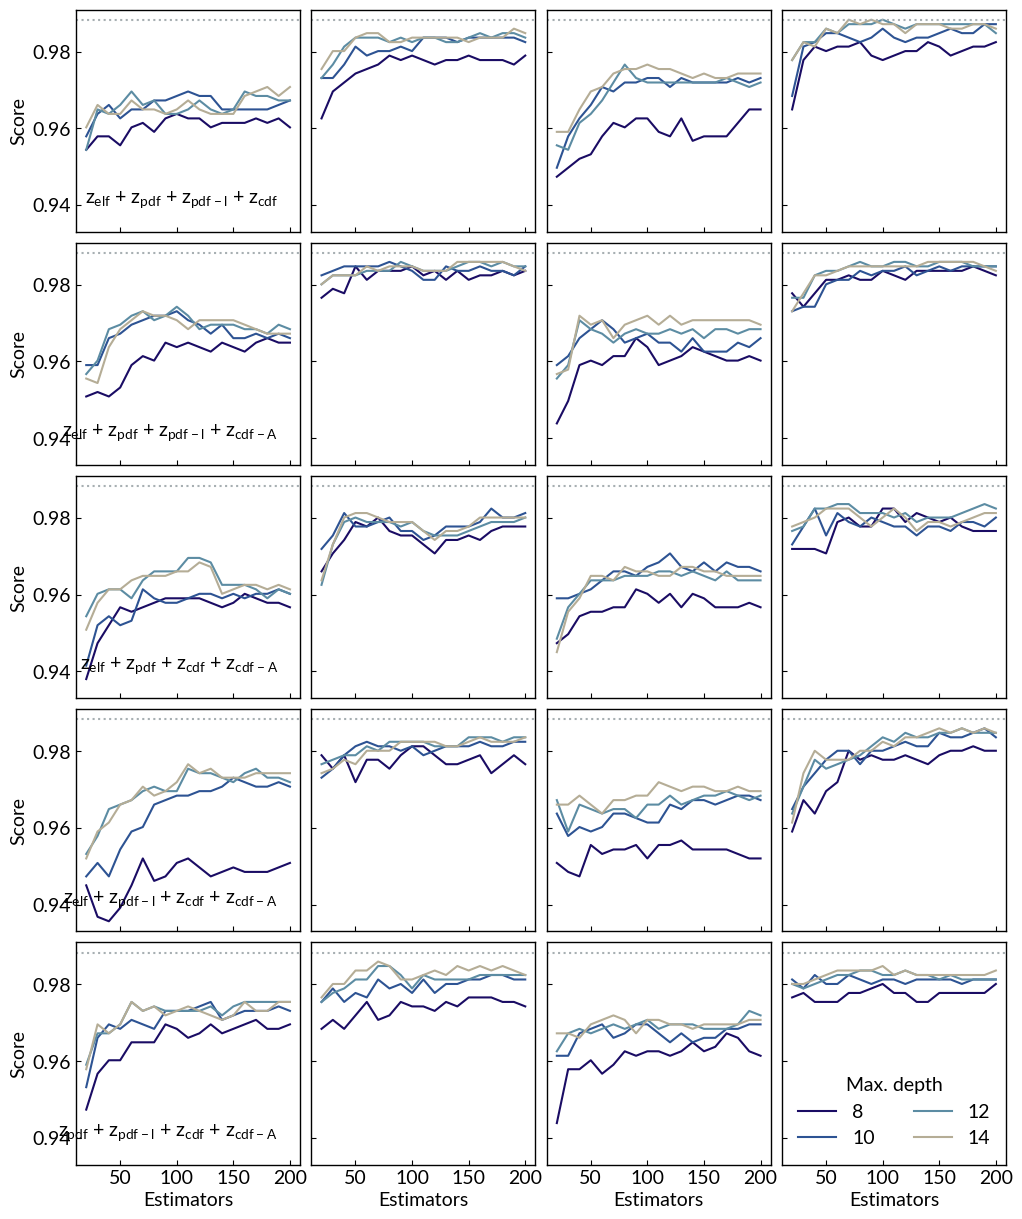

In [204]:
fig = models[0].plot_scores(oob_scores, columns, features, n_estimators, max_depth)

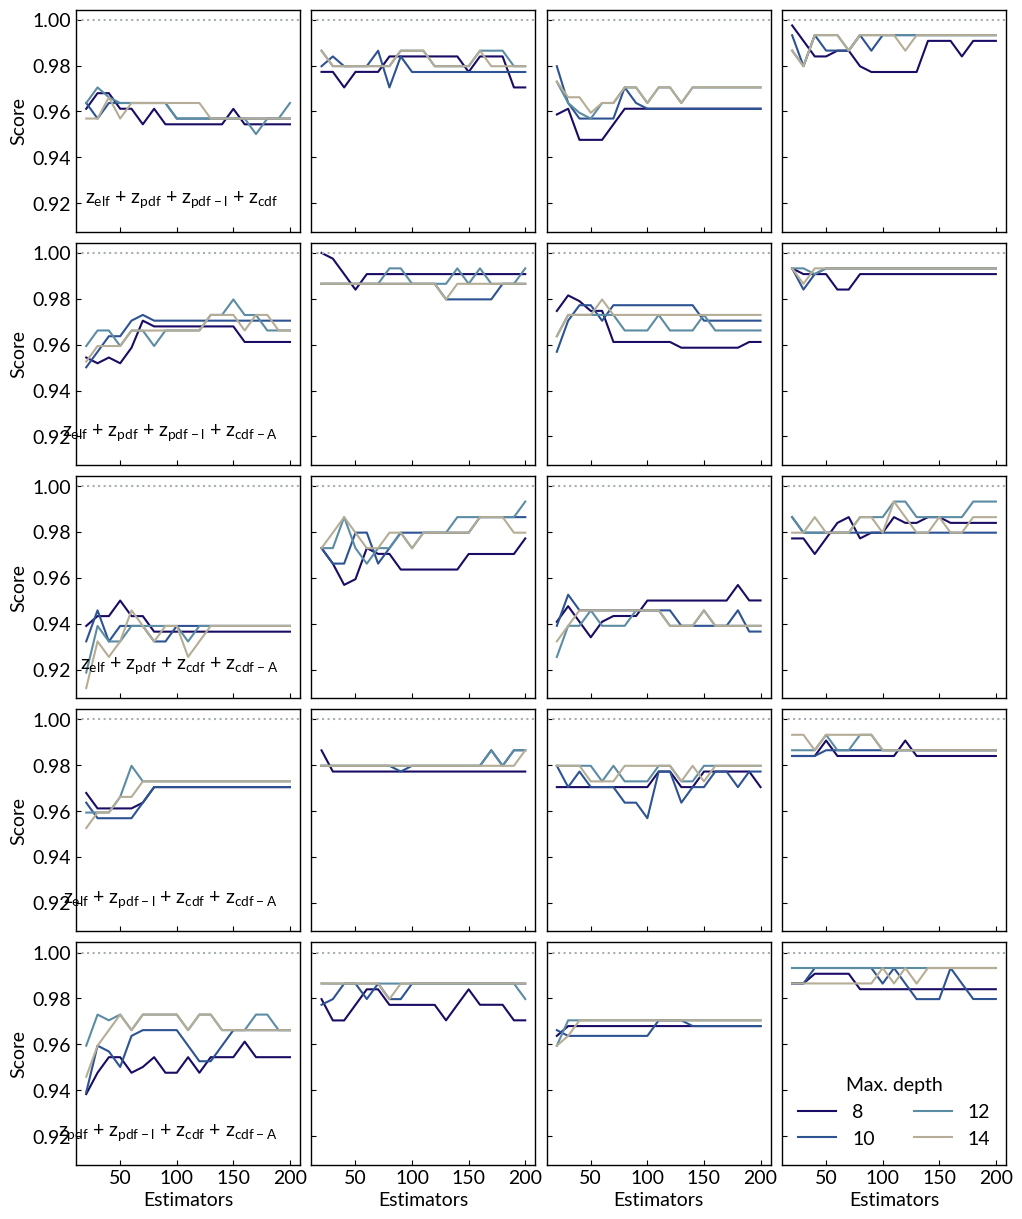

In [205]:
fig = models[0].plot_scores(scores, columns, features, n_estimators, max_depth)

## Train classifiers

In [206]:
savedir = 'models/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [323]:
n_classes = 4
n_components = 10
columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
#columns = [['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']]
columns = [['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt'],
           ['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf-A_srt'],
           ['elf_srt', 'pdf_srt', 'cdf_srt', 'cdf-A_srt'],
           ['elf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt'],
           ['pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']]
features = ['l','A']

### Featurize data

In [324]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Scale data

In [325]:
for i in range(len(models)):
    models[i].set_inputs(['z_' + k for k in columns[i]] + features)
    models[i].scaler_fit(unlabeled.data_nodup)

### Split data

In [326]:
test_size = 0.2
valid_size = 0.2

In [327]:
idx_train, idx_test = models[0].split(labeled.data_nodup, test_size, stratify=True)

y_train = models[0].bond_to_float(labeled.data_nodup.iloc[idx_train]['label'].tolist())
y_test = models[0].bond_to_float(labeled.data_nodup.iloc[idx_test]['label'].tolist())
class_weight = len(y_train)/(n_classes*np.bincount(y_train))

print('Train (Total):', len(idx_train), '\tTest:', len(idx_test))
print('Train (Bootstrap):', round((1 - valid_size)*len(idx_train)),
      '\tValid (Bootstrap):', round(valid_size*len(idx_train)))
print('Class weights:', list(class_weight))

Train (Total): 855 	Test: 214
Train (Bootstrap): 684 	Valid (Bootstrap): 171
Class weights: [0.5370603015075377, 1.3194444444444444, 1.4540816326530612, 1.4442567567567568]


### Train classifiers

In [328]:
n_estimators = 150
max_depth = 12
n_features = n_components*len(columns[0]) + len(features)
feature_importance = np.zeros((len(columns), n_features))
scores = np.zeros(len(columns))
oob_scores = np.zeros(len(columns))
_scores = np.zeros((len(columns), n_estimators))

In [329]:
for i in tqdm(range(len(columns)), bar_format=labeled.bar_format):
    models[i].prepare_inputs(labeled.data_nodup)
    x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
    x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)
    
    models[i].clf_init(n_estimators, max_depth, 1 - valid_size)
    models[i].clf.fit(x_train, y_train)
    feature_importance[i,:] = models[i].clf.feature_importances_
    scores[i] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])
    oob_scores[i] = models[i].clf.oob_score_
    
    for j in range(n_estimators):
        _scores[i,j] = models[i].clf.estimators_[j].score(x_test, y_test, sample_weight=class_weight[y_test])

100%|██████████| 5/5 [00:01<00:00,  2.97it/s]                                   


In [330]:
scores

array([0.99749628, 0.99749628, 0.98653403, 0.97725152, 0.99749628])

In [331]:
oob_scores

array([0.98362573, 0.98479532, 0.9871345 , 0.98479532, 0.98596491])

[0.91265303 0.91383793 0.91847724 0.90868081 0.91711814]


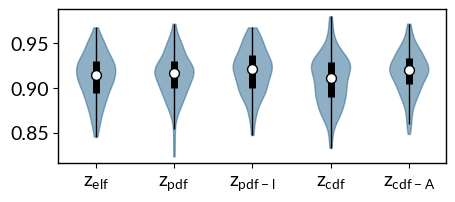

In [333]:
fig = models[0].plot_violins(_scores, columns)
#fig._localaxes[0].set_xticklabels(fig._localaxes[0].get_xticklabels(), rotation=30, ha='right')
print(_scores.mean(axis=-1))

In [249]:
_feature_importance = np.zeros((len(columns), n_estimators, n_features))
for i in range(len(columns)):
    for j in range(n_estimators):
        _feature_importance[i,j] = models[i].clf.estimators_[j].feature_importances_

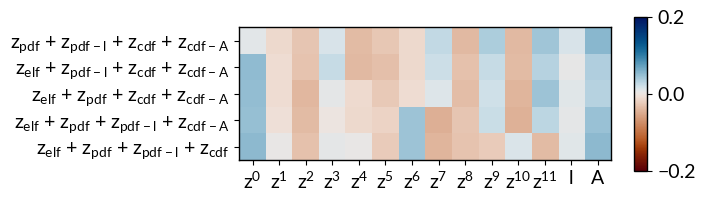

In [273]:
fig = models[0].plot_importances(feature_importance - 1./n_features,
                                 columns, features, vmin=-0.2, vmax=0.2, cmap=cm.vik_r)

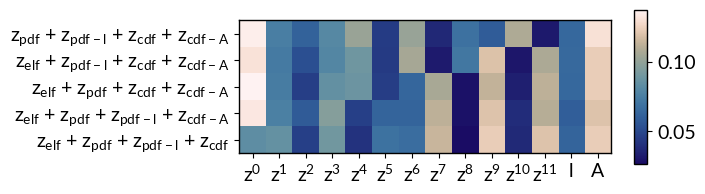

In [274]:
fig = models[0].plot_importances(_feature_importance.std(axis=1), columns, features)

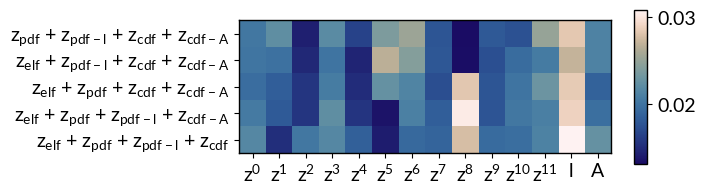

In [275]:
_feature_importance_cov = _feature_importance.mean(axis=1)/_feature_importance.std(axis=1)/(1 + 0.25*n_estimators)
fig = models[0].plot_importances(_feature_importance_cov, columns, features)

### Save models

In [253]:
if len(columns[0][0].split('_')) > 1:
    tag = '_' + columns[0][0].split('_')[-1]
else:
    tag = ''
        
for i in range(len(models)):
    column_name = '_'.join([''.join(k.split('_')[:-1]) for k in columns[i]]) + tag
    path = '_'.join([j + str(k) for (j,k) in zip(['c', 'z', 'n', 'd'],
                     [n_classes, n_components, n_estimators, max_depth])] + [column_name] + features)
    if center:
        path += '_cen'
        
    models[i].save_model(savedir + path)

## Cross-validate

In [365]:
n_classes = 3
n_components = 10
columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
features = ['l','A']

### Featurize data

In [366]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Scale data

In [367]:
for i in range(len(models)):
    models[i].set_inputs(['z_' + k for k in columns[i]] + features)
    models[i].scaler_fit(unlabeled.data_nodup)

### Split data

In [368]:
test_size = 0.2
valid_size = 0.2
n_folds = 10
kfold = models[0].split_kfold(n_folds, test_size)

### Train classifiers

In [369]:
n_estimators = 175
max_depth = 12
n_features = n_components*len(columns[0]) + len(features)
scores = np.zeros((len(columns), n_folds))

In [370]:
y = models[0].bond_to_float(labeled.data_nodup['label'].tolist())

for i in tqdm(range(len(columns)), bar_format=labeled.bar_format):
    models[i].prepare_inputs(labeled.data_nodup)
    
    for j, (idx_train, idx_test) in enumerate(kfold.split(np.zeros(len(y)), y)):
        x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
        x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)
        y_train = y[idx_train]
        y_test = y[idx_test]
        class_weight = len(y_train)/(n_classes*np.bincount(y_train))
        
        models[i].clf_init(n_estimators, max_depth, 1 - valid_size)
        models[i].clf.fit(x_train, y_train)
        scores[i,j] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]                                   


[0.98880413 0.99080703 0.9912574  0.9856357  0.98668468]


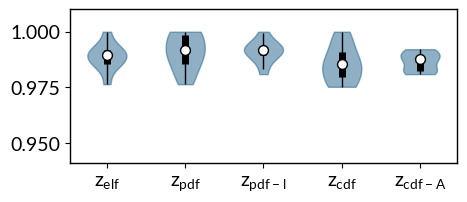

In [110]:
fig = models[0].plot_violins(scores, columns)
plt.ylim([0.941,1.01])
print(scores.mean(axis=-1))